In [ ]:
# --------------------------------------------------------------
# Name: Analog Spiking Neuron Model for Unsupervised STDP-based learning in Neuromorphic Circuits
# Author: Yannaël Bossard
# Date: 2024-05-29
# Source: https://github.com/YannaelB 
# Description: 

'''
This Jupyter notebook provides an interactive and visual exploration of the initial steps
involved in training and testing an eSNN on the MNIST dataset. It is designed to help users 
understand and observe the state and variables throughout the training and testing processes.



The code below implements unsupervised STDP-based learning within a eSNN
using complete model of a Morris-Lecar electronic neuron and conductance-based synapses.
The neuron model is derived from the post layout simulation results
of its analog circuit from Ferreira et al. (2019)

The training, labeling, and evaluation processes are inspired by the methodology of Diehl&Cook (2015).
To maintain effective unsupervised learning, training, labeling and testing are implemented as three distinct
functions. However a training function with continous labeling and testing is also feasible.

Here, the eSNN is tested on the XOR problem. 
The eSNN is trained with noiseless neurons (SCENARIO 3 in the paper)

This code employs the architecture : [2,13]+exci+inhi+wta.
It means that there is 2 input neurons fully connected with 13 outputs neurons
with both excitatory and inhibitory synapses conducted with STDP rules. Plus, there is a lateral inhibition
playing a soft-Winner-Take-All synaptic connection between output neurons. It implies 208 synapses.
'''
# --------------------------------------------------------------


import csv
import re
import os
from brian2 import *
import numpy as np
from scipy.interpolate import interp1d
import brian2.numpy_ as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from scipy.interpolate import griddata
import time
import warnings
from tqdm import tqdm
import random
from random import shuffle
import pandas as pd
import pickle

### Collection of utility functions to support the main functionality below

In [ ]:
def batch_data(n_train,n_test):
    '''
        Function that creates input data for the XOR problem
    In input:
        - n_train is the number of binary input [[0,0],[0,1],[1,0],[1,1]] for training the eSNN to XOR problem
        - n_test is the number of binary input [[0,0],[0,1],[1,0],[1,1]] for testing the eSNN to XOR problem
    It returns:
        - 2 vectors of length (n_train*4,2) and (n_train*4,1)
        - 2 vectors of length (n_test*4,2) and (n_test*4,1)
    '''
    X_train = n_train*[[0,0]] + n_train*[[0,1]] + n_train*[[1,0]] + n_train*[[1,1]]
    shuffle(X_train)
    y_train = [a ^ b for a, b in X_train]

    X_test = n_test*[[0,0]] + n_test*[[0,1]] + n_test*[[1,0]] + n_test*[[1,1]]
    shuffle(X_test)
    y_test = [a ^ b for a, b in X_test]
    
    return X_train,y_train,X_test,y_test

def from_bit_to_current(x):
    '''
        Function that converts binary into input current
    In input:
        - binary input (list)
    It returns:
        - binary input converting into input current (list without unit (/nA))
    '''
    if x == [0,0]:
        return [0.3,0.3]
    elif x == [0,1]:
        return [0.3,2]
    elif x == [1,0]:
        return [2,0.3]
    elif x == [1,1]:
        return [2,2]
    else:
        print(" WARNING PROBLEM !")
        
def from_bit_to_label_2(x):
    '''
        Function that converts binary input into binary output. It is helpful for saving SNN behavior
    In input:
        - binary input (list)
    It returns:
        - Xor operation of the input (scalar)
    '''
    if x == [0,0]:
        return 0
    elif x == [0,1]:
        return 1
    elif x == [1,0]:
        return 1
    elif x == [1,1]:
        return 0
    else:
        print(" WARNING PROBLEM !")
        
def from_bit_to_label_4(x):
    '''
        Function that converts binary input into scalar output. It is helpful for saving SNN behavior
    In input:
        - binary input (list)
    It returns:
        - scalar
    '''
    if x == [0,0]:
        return 0
    elif x == [0,1]:
        return 1
    elif x == [1,0]:
        return 2
    elif x == [1,1]:
        return 3
    else:
        print(" WARNING PROBLEM !")
        
def from_label_to_XOR(x):
    '''
        Function that converts input scalar into binary XOR operation. It is helpful for saving SNN behavior
    In input:
        - (scalar)
    It returns:
        - binary XOR (scalar)
    '''
    if x == 0:
        return 0
    elif x == 1:
        return 1
    elif x == 2:
        return 1
    elif x == 3:
        return 0
    else:
        print(" WARNING PROBLEM !")


def weight_evolution(weight_evol_exci,weight_evol_inhi,label_buffer):
    ''''
        Function that display a graph of the evolution of the synaptic weights conducted by STDP rules 
    In input:
        - 2 lists of the evolution of the synaptic weights conducted by STDP rules 
        - n_output: number of neurons on the output layer
    It returns:
        - Nothing, it plots the graph
    '''
    
    for k in range(len(weight_evol_exci)):
        plt.figure()
        weight_visu = np.zeros((5,13))
        weight_visu[:2,:] = np.reshape(weight_evol_exci[k], (2, 13))
        weight_visu[2:4,:] = np.reshape(weight_evol_inhi[k], (2, 13))
        weight_visu[4,:] = label_buffer

        plt.imshow(weight_visu, cmap='gray', interpolation='nearest')
        plt.savefig(f"{directory+str(itera)}/weight_evolution_epch_{10*k}.png")
        plt.close()



def plot_accuracy_evol(accuracy_evol,n_output):
    ''''
        Function that display a graph of the average evolution of the accuracies (3 used criterias)
    In input:
        - list of the accuracies evolution
        - n_output: number of neurons on the output layer
    It returns:
        - Nothing, it saves and plots the graph if plot==True
    '''
    plt.figure(figsize=(10, 6)) 
    plt.plot(range(len(accuracy_evol)),accuracy_evol,label="max criteria")
    plt.title(' accuracy evolution ')
    plt.xlabel(f' epoch  ')
    plt.ylabel(' accuracy ')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"{directory}/accuracy_evol_epoch_{n_output}output.png")
    plt.close()


def input_3D_vec(n_point = 5):
    '''
        Function that creates this axis and input for the 3D graphs of the prediction from the SNN (post-trained-XOR problem)
    In input:
        - n_point: number of point on 1 axis of the 3D graph
    It returns:
        - X_3D represents x-axis on the 3D graph (size list (n_point**2,1))
        - Y_3D represents x-axis on the 3D graph (size list (n_point**2,1))
        - input_3D_current is the input list for the SNN (size list (n_point**2,2))
    '''
    binary_list = [i / (n_point - 1) for i in range(n_point)]

    input_3D = np.zeros((2,len(binary_list)**2))
    X_3D,Y_3D = [],[]
    input_3D_current = []

    k = 0
    for i,binary_x in enumerate(binary_list):
     
        for j,binary_y in enumerate(binary_list):
            input_3D[0,k], input_3D[1,k] = binary_x,binary_y
            X_3D.append(binary_x)
            Y_3D.append(binary_y)
            input_3D_current.append([0.3+1.7*binary_x,0.3+1.7*binary_y])
            k+=1

    return X_3D,Y_3D,input_3D_current


def reducing_list(original_list, new_size):
    '''
        Function that reduces the size of a list and lessen the amount of computation
    In input:
        - Original_list: list you want to reduce in size
        - new_size: size desired for the list
    It returns:
        - Similar list with desired size
    '''
    original_size = len(original_list)
    if new_size >= original_size:
        return original_list  

    # Calculate the sampling interval
    interval = original_size / new_size

    # Sample elements at regular intervals
    new_list = [original_list[int(i * interval)] for i in range(new_size)]

    return new_list


def extracting_eNeuron_behavior(csv_file_path,nb_point_interpolation):
    '''
        Function that extrates data from the transfer function of th eNeuron ML in order to define a linear-
        interpolation function
    In input:
        - path of the csv file containing the transfer function of the eNeuron
        - nb_point_interpolation: size of the interpolated list
    It returns:
        - i_new: x-axis of the interpolated function (amp)
        - f_new: y-axs of the interpolated function (Hz)
    '''

    input_current = []
    spike_rate = []

    # Open the CSV file
    with open(csv_file_path, 'r') as file:
        csv_reader = csv.reader(file, delimiter='\t')
        next(csv_reader)
        for row in csv_reader:
            values = re.split(r',', row[0])
            input_current.append(float(values[0]))
            spike_rate.append(float(values[1]))

    prefs.codegen.target = 'numpy'
    i_new = reducing_list(input_current,nb_point_interpolation)
    f_new = reducing_list(spike_rate,nb_point_interpolation)

    # Convert data to use with Brian2
    i_new = i_new * amp
    f_new = f_new * Hz
    
    return i_new, f_new


def save_accuracy_txtfile(filename, n_output, n_epoch,accuracy_max,accuracy):
    '''
        Function that saves accuracy results to a text file
    '''
    with open(filename, 'a') as file:
        file.write(f"\n Method unsupervised with  {n_output} output neurons: \n")
        file.write(f" It has taken "+ str(n_epoch) +f" epoch for reaching {accuracy_max*100} '%' accuracy \n")
        file.write(" The three observed accuracy are are the end of the training = ")
        accuracy_str = np.array_str(accuracy)
        file.write(accuracy_str)
        file.write("\n")
        file.write("\n")


def csv_save(title,vecteur):
    '''
        Function that saves data to a CSV file. Those files can be processed with 'main_processing.py'
    '''
    with open(f'{title}', 'a', newline='') as fichier:
        writer = csv.writer(fichier)
        writer.writerow(vecteur)

#### Define the eNeuron model + synapses + STDP

In [1]:
from brian2 import clear_cache
from brian2 import device
device.reinit()
start_scope()

# Simulation parameters
defaultclock.dt = 0.01*us  
time_per_sample = 100 * us
resting_time = 20 * us

# Defining the linear interpolation of the eNeuron ML behavior
i_new, f_new = extracting_eNeuron_behavior(csv_file_path='FT_augmented.csv',nb_point_interpolation=1111)
interp_function = interp1d(i_new, f_new, kind='linear', fill_value='extrapolate',assume_sorted=True)

@check_units(x=amp, result = Hz)
def y_interp_function(x):
    return interp_function(x)*Hz

#Model parameters
v_rest = -80*mV
v_threshold = 60*mV  
v_std_thresh = 3*mV 
v_reset = -100*mV
v0 = -40*mV  
tau = 500*us
tau2 = 15*us
Rm = 5000*Mohm
I0=1*amp
max_input_current = i_new[-1]


a_v = 1126.6343973469338
b_v = 169200.45773494235
a_value = 6.23667974e13

x_threshold_v= 8.3e-11*amp
q, R_ds,C_m = 1.6*1e-19*amp*second, 5*ohm, 5*1e-8*second/ohm
avoid_error = 0.01*pA
frequency_min = 0.1*Hz
refrac = 0*us
alpha_e = 0.15
alpha_i = 0.04
beta_e = 1.9
beta_i = 0.5
avoid_error = 0.01*pA



@check_units(x=amp, result = amp)
def max_function_I(x):
    #print(" in function max current, x = ",x)
    y = [max(i,avoid_error) for i in x]
    #print(" AFTER PROcess in function max current, x = ",x)
    return y



V_x, V_y, V_z= 8*mV,62*mV,90*mV
R_x = Rm*(V_x/mV)/(15/60)/(abs(v_threshold/mV)+abs(v_reset/mV))  #New resistance for rising till V_a
R_y = Rm*(V_y/mV)/(35/60)/(abs(v_threshold/mV)+abs(v_reset/mV)) #New resistance for rising till V_b
R_z = Rm*(V_z/mV)/(10/60)/(abs(v_threshold/mV)+abs(v_reset/mV)) #New resistance for rising till V_b
k_redres = 0.007704519252680564
k_redres = -0.0018141002616710589

# This model use a constant Resistance and a log approximation
neuron_eqs_v1 = '''
dv/dt = (v_rest - v) / tau2 + redress*((y_interp_function(I_total)*I0/(a_value*Hz))*Rm)/ tau : volt (unless refractory)
I_total = clip(Ie + I_inhi + I, 0*nA, 12*nA) : amp
Ie =  alpha_e*ge * uS *(80*mV -v)           : amp
I_inhi =  alpha_i*gi * uS *(-120*mV -v)           : amp
I : amp
redress = 1+ k_redres*I_total/max_input_current     : 1
dge/dt = -ge/(beta_e*us)            : 1
dgi/dt = -gi/(beta_i*us)            : 1
Rm = (R_x)*int(v<=(v_reset+V_x)) + (R_y)*int(v<=(v_reset+V_x+V_y))*(1-int(v<(v_reset+V_x))) + (R_z)*int(v>(v_reset+V_x+V_y)) : ohm

threshold = v_threshold + 0*int(noise_activity)*v_std_thresh*randn() : volt (constant over dt)
noise_activity : boolean (shared) # (un)Activate the noise
'''

reset_eqs = '''
v = v_reset
'''



#STDP parameters
tau_stdp = 3.98116837
mag_stdp = 0.007070372048
mag_stdp = 0.00230372048


taupre = tau_stdp*us
taupost = taupre
wmax = 1
dApre = mag_stdp
dApost = -dApre * taupre / taupost * 1.05

stdp_eqs_exci = '''
    w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)
'''
pre_eqs_exci='''
    ge_post += w
    Apre += dApre
    w = clip(w + 0.2*lr*Apost, 0, wmax)
'''
post_eqs_exci='''
    Apost += dApost
    w = clip( w*(1-0.0005*lr) + lr*Apre, 0, wmax)
'''

stdp_eqs_inhi = '''
    w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)
'''
pre_eqs_inhi='''
    gi_post += w
    Apre += dApre
    w = clip(w + 0.2*lr*Apost, 0, wmax)
'''
post_eqs_inhi='''
    Apost += dApost
    w = clip( w*(1-0.0005*lr) + lr*Apre, 0, wmax)
'''

synapse_model = "w : 1"

n_input, n_output = 2,13
n_label = 8

In [2]:
class SNN_eNeuron():
    def __init__(self, debug=False):
        '''
            Initialization including setting up neuron groups and synapses
        '''

        from brian2 import clear_cache
        from brian2 import device
        device.reinit()
        start_scope()

        # Simulation parameters
        defaultclock.dt = 0.05*us  

        model = {}

        model['input'] = NeuronGroup(N=n_input, model=neuron_eqs_v1, threshold='v >= threshold', reset=reset_eqs, refractory='refrac', method='heun',name='input')
        model['input'].noise_activity = False

        model['output'] = NeuronGroup(N=n_output, model=neuron_eqs_v1, threshold='v >= threshold', reset=reset_eqs, refractory='refrac', method='heun',name='output')
        model['output'].noise_activity = False

        model['input_synapse_exci'] = Synapses(model['input'], model['output'], model=stdp_eqs_exci, on_pre=pre_eqs_exci, on_post=post_eqs_exci,name='input_synapse_exci')
        model['input_synapse_exci'].connect(True)
        model['input_synapse_exci'].lr = 0.5
        model['input_synapse_exci'].w = 'rand() * wmax * 0.8 + 0.1*wmax'
        model['input_synapse_exci'].delay = 'rand()*0*us'

        model['input_synapse_inhi'] = Synapses(model['input'], model['output'], model=stdp_eqs_inhi, on_pre=pre_eqs_inhi, on_post=post_eqs_inhi,name='input_synapse_inhi')
        model['input_synapse_inhi'].connect(True)
        model['input_synapse_inhi'].lr = 0.5
        model['input_synapse_inhi'].w = 'rand() * wmax * 0.8 + 0.1*wmax'
        model['input_synapse_inhi'].delay = 'rand()*0*us'

        model['wta_synapse'] = Synapses(model['output'], model['output'], model=synapse_model, on_pre='gi_post += w',name='wta_synapse')
        model['wta_synapse'].connect(condition='i != j')
        model['wta_synapse'].w = 'rand() * wmax * 1.3 + 0.8*wmax'
        model['wta_synapse'].delay = 'rand()*0*us'

        model['output_SP'] = SpikeMonitor(model['output'], record=False,name='output_SP')

        if (debug):
            model['input_SP'] = SpikeMonitor(model['input'], record=True,name='input_SP')
            model['output_SP'] = SpikeMonitor(model['output'], record=True,name='output_SP')
            model['ESM'] = StateMonitor(model['output'], ['v','Ie','I_inhi','I_total'], record=True, name='ESM')
            model['ISM'] = StateMonitor(model['input'], ['v','Ie','I_inhi','I_total'], record=True, name='ISM')
            
            model['S1M'] = StateMonitor(model['input_synapse_exci'], ['w', 'Apre', 'Apost'], record=model['input_synapse_exci'][1,:4], name='S1M') 

        print("You've created :",len(model['input_synapse_exci'])+len(model['input_synapse_inhi'])+len(model['wta_synapse']) , "synapses in your network")

        self.net = Network(model)
        
        self.weight_evol_exci = []
        self.weight_evol_inhi = []
        self.accuracy_evol = []

    def __getitem__(self,key):
        return self.net[key]

    def training(self,idx_epoch,X_train,y_train,noise=True,plot=False,save_secure = False):
        '''
            Training function with synaptic normalization and weight observation
        '''

        tic = time.time()
        
        # (un)Activate noise during training
        self.net['input'].noise_activity = noise
        self.net['output'].noise_activity = noise

        self.net['input_synapse_exci'].lr = 1
        self.net['input_synapse_inhi'].lr = 1

        old_spike_counts = np.zeros(n_output)
        old_spike_counts = np.copy(self.net['output_SP'].count)
        
        
        spikes_buffer = self.spikes_buffer
        
        
        accuracy_buffer = self.accuracy_buffer
        self.accuracy_evol.append(sum(accuracy_buffer)/n_label)        
        
        for j, (sample, label) in enumerate(zip(X_train, y_train)):

            self.net['input'].I = from_bit_to_current(sample) * nA
            self.net['input'].v = v_rest
            self.net['output'].v = v_rest

            # Start the training simulation
            self.net.run(time_per_sample)
            counter_spike = self.net['output_SP'].count - old_spike_counts
            
            # Allow the variables to return to their resting values
            self.net['input'].I = 0 * nA
            self.net.run(resting_time) 
            self.net['input'].v = v_rest
            self.net['output'].v = v_rest
            
            old_spike_counts = np.copy(self.net['output_SP'].count)
            
            
            # Remove the first column by slicing the matrix from the second column onwards
            spikes_buffer = spikes_buffer[:,:, 1:]
            # Add the last spikes vector
            vector = np.zeros((2,n_output,1))
            vector[from_bit_to_label_2(sample)] = np.array([counter_spike]).T
            spikes_buffer = np.concatenate((spikes_buffer, vector), axis=2)

            
            
            
            
            # Prediction of the SNN post labelisation
            output_label_max2 = self.label_buffer[np.argmax(counter_spike)]

            correct_pred = False
            if output_label_max2 == int(label):
                correct_pred = True
                
            # delete first element and add the last result
            accuracy_buffer[:-1] = accuracy_buffer[1:]
            accuracy_buffer[-1] =  int(correct_pred)            
            
            #NORMALISATION :
            weight_matrix = np.zeros([n_input, n_output])
            weight_matrix[self.net['input_synapse_exci'].i, self.net['input_synapse_exci'].j] = self.net['input_synapse_exci'].w
            sumCol = np.sum(weight_matrix, axis=0)
            colFactors = 1/sumCol
            for jj in range(n_output):
                weight_matrix[:,jj] *= colFactors[jj]
            self.net['input_synapse_exci'].w = weight_matrix[self.net['input_synapse_exci'].i, self.net['input_synapse_exci'].j]

            weight_matrix = np.zeros([n_input, n_output])
            weight_matrix[self.net['input_synapse_inhi'].i, self.net['input_synapse_inhi'].j] = self.net['input_synapse_inhi'].w
            sumCol = np.sum(weight_matrix, axis=0)
            colFactors = 0.5/sumCol
            for jj in range(n_output):
                weight_matrix[:,jj] *= colFactors[jj]
            self.net['input_synapse_inhi'].w = weight_matrix[self.net['input_synapse_inhi'].i, self.net['input_synapse_inhi'].j]

            
            if j >= 4 and j<5 and idx_epoch <10 and plot:
                
                start_time = idx_epoch*3 * ms  
                input_mask = (self.net['input_SP'].t >= start_time)
                output_mask = (self.net['output_SP'].t >= start_time)
            
                plt.figure(figsize=(20, 10)) 
                plt.plot(self.net['input_SP'].t[input_mask] / second, self.net['input_SP'].i[input_mask], '.b', label='input')
                plt.plot(self.net['output_SP'].t[output_mask] / second, self.net['output_SP'].i[output_mask], '.r', label='output')

                plt.ylabel('Neuron index')
                plt.xlabel('time (us)')
                plt.title("raster plot")
                plt.legend()
                plt.show()
                
        #Observation weight evolution
        weight = [self.net['input_synapse_exci'].w[i] for i in range(len(self.net['input_synapse_exci'].w))]
        self.weight_evol_exci.append(weight)
        weight = [self.net['input_synapse_inhi'].w[i] for i in range(len(self.net['input_synapse_inhi'].w))]
        self.weight_evol_inhi.append(weight)

        ######
        label_buffer = np.sum(spikes_buffer, axis=2)
        label_buffer = np.argmax(label_buffer, axis=0)
        redundancy_buffer = np.bincount(label_buffer, minlength=2)
        #print(" into TRAINING, labeled_buffer = ", label_buffer)
        #print("  into TRAINING, redundancy_neuron_conti = ", redundancy_buffer)

        self.accuracy_evol.append(sum(accuracy_buffer)/n_label)
        #print(" TRANING accuracy_evol = ", self.accuracy_evol)
        
        if save_secure:
            weight_wta = np.zeros((n_output*(n_output-1)))
            weight_wta = np.copy(self.net['wta_synapse'].w)
            
            files = [
                f'{directory+str(itera)}/weightfile_exci_epch{idx_epoch-1}',
                f'{directory+str(itera)}/weightfile_inhi_epch{idx_epoch-1}',
                f'{directory+str(itera)}/weightfile_wta_epch{idx_epoch-1}',
                f'{directory+str(itera)}/labelfile_epch{idx_epoch-1}',
                f'{directory+str(itera)}/accuracyfile_epch{idx_epoch-1}',
                f'{directory+str(itera)}/accuracy_evolfile_epch{idx_epoch-1}'
            ]
            for file in files:
                if os.path.exists(file):
                    os.remove(file)

            with open(f'{directory+str(itera)}/weightfile_exci_epch{idx_epoch}', 'wb') as fp:
                pickle.dump(self.weight_evol_exci[-1], fp)
            with open(f'{directory+str(itera)}/weightfile_inhi_epch{idx_epoch}', 'wb') as fp:
                pickle.dump(self.weight_evol_inhi[-1], fp)
            with open(f'{directory+str(itera)}/weightfile_wta_epch{idx_epoch}', 'wb') as fp:
                pickle.dump(weight_wta, fp)
            with open(f'{directory+str(itera)}/labelfile_epch{idx_epoch}', 'wb') as fp:
                pickle.dump(label_buffer, fp)
            with open(f'{directory+str(itera)}/accuracyfile_epch{idx_epoch}', 'wb') as fp:
                pickle.dump(accuracy_buffer, fp)
            with open(f'{directory+str(itera)}/accuracy_evolfile_epch{idx_epoch}', 'wb') as fp:
                pickle.dump(self.accuracy_evol, fp)

        
            
            
        print(" TRAINING lasts : ", time.time() - tic, " s")
        return self.accuracy_evol, label_buffer,accuracy_buffer,self.weight_evol_exci, self.weight_evol_inhi
                


    def labelisation(self,idx_epoch,X_train,y_train,noise=False,plot=False):
        '''
            Function for labeling output neurons based on their response to inputs
        '''

        tic = time.time()
        self.net['input'].noise_activity = noise
        self.net['output'].noise_activity = noise

        # Desactivate STDP plasticity
        self.net['input_synapse_exci'].lr = 0
        self.net['input_synapse_inhi'].lr = 0

        spikes2 = np.zeros((2, n_output))

        old_spike_counts = np.zeros(n_output)
        old_spike_counts = np.copy(self.net['output_SP'].count)        
    
        spikes_buffer = np.zeros([2,n_output, n_label])

        for j, (sample, label) in enumerate(zip(X_train, y_train)):

            self.net['input'].I = from_bit_to_current(sample) * nA
            self.net['input'].v = v_rest
            self.net['output'].v = v_rest

            # Start the simulation
            self.net.run(time_per_sample)
            counter_spike = self.net['output_SP'].count - old_spike_counts
            spikes2[from_bit_to_label_2(sample)] += counter_spike  
            
            spikes_buffer[from_bit_to_label_2(sample),:,j%n_label] = counter_spike

            # Allow the variables to return to their resting values
            self.net['input'].I = 0 * nA
            self.net.run(resting_time) 
            self.net['input'].v = v_rest
            self.net['output'].v = v_rest

            old_spike_counts = np.copy(self.net['output_SP'].count)
        
        if plot:
            plt.figure()
            label_list = [[0],[1]]
            for i in range(len(spikes2)):
                if spikes2[i].any() != np.zeros(len(spikes2[i])).any():
                    plt.plot(range(len(spikes2[i])),spikes2[i], label=f'label {label_list[i]}')
            plt.legend()
            plt.show()
        
        
        label_buffer = np.sum(spikes_buffer, axis=2)
        label_buffer = np.argmax(label_buffer, axis=0)
        redundancy_neuron = np.bincount(label_buffer, minlength=2)
        
        if plot:
            plt.figure()
            bar(range(len(redundancy_neuron)),redundancy_neuron)
            xticks(range(len(redundancy_neuron)))
            plt.show()
            #print(" label_buffer = ", label_buffer)
            #print(" redundancy_neuron = ", redundancy_neuron)
        
        
        print(" Labeling lasted : ", time.time() - tic, " s")
        self.redundancy_neuron = redundancy_neuron
            
        self.spikes_buffer = spikes_buffer
        self.label_buffer = label_buffer

        
    def evaluation(self,idx_epoch,X_test,y_test,noise=False,plot=False):
        '''
            Evaluation function that tests the trained network on test data and calculate accuracy
        '''
        # Activate the noise
        self.net['input'].noise_activity = noise
        self.net['output'].noise_activity = noise

        # Desactivate STDP plasticity
        self.net['input_synapse_exci'].lr = 0
        self.net['input_synapse_inhi'].lr = 0

        spikes2 = np.zeros((2, n_output))

        old_spike_counts = np.zeros(n_output)
        old_spike_counts = np.copy(self.net['output_SP'].count)

        num_correct_output_max2 = 0
      
        accuracy_2 = np.zeros((2,1))
        
        accuracy_buffer = np.zeros(n_label)

        for j, (sample, label) in enumerate(zip(X_test, y_test)):
            self.net['input'].I = from_bit_to_current(sample) * nA
            self.net['input'].v = v_rest
            self.net['output'].v = v_rest
            
            correct_pred = False

            # Start the simulation
            self.net.run(time_per_sample)
            counter_spike = self.net['output_SP'].count - old_spike_counts
            spikes2[from_bit_to_label_2(sample)] += counter_spike    
            
            # Prediction of the SNN post labelisation
            output_label_max2 = self.label_buffer[np.argmax(counter_spike)]

            # Check prediction of the class of the sample
            if j < 8:
                pass
                #print("output_label_max2 = ", output_label_max2,"output_label_mean2 = ",output_label_mean2,"output_label_temporal2 = ",output_label_temporal2, " and int(label) = ", int(label))
                #print("output_label_max4 = ", output_label_max4,"output_label_mean4 = ",output_label_mean4,"output_label_temporal4 = ",output_label_temporal4, " and int(label) = ", int(label))
            if output_label_max2 == int(label):
                num_correct_output_max2 += 1
                accuracy_2[from_bit_to_label_2(sample)] += 2/len(X_test)
                correct_pred = True
                
            accuracy_buffer[j%n_label] = int(correct_pred)
        

            # Allow the variables to return to their resting values
            self.net['input'].I = 0 * nA
            self.net.run(resting_time) 
            self.net['input'].v = v_rest
            self.net['output'].v = v_rest

            old_spike_counts = np.copy(self.net['output_SP'].count)


        accuracy_max = (num_correct_output_max2 / len(y_test))
        self.accuracy_evol.append(accuracy_max)

        if plot:
            plt.figure()
            plt.subplot(1, 2, 1)  
            label_list = [[0],[1]]
            for i in range(len(spikes2)):
                if spikes2[i].any() != np.zeros(len(spikes2[i])).any():
                    plt.plot(range(len(spikes2[i])),spikes2[i], label=f'label {label_list[i]}')
            plt.legend()

            plt.show()
            
        self.accuracy_buffer = accuracy_buffer

        return accuracy_max, self.weight_evol_exci, self.weight_evol_inhi,self.label_buffer

    def plot_3D_XOR(self,idx_epoch,n_point=5,noise=True,plot=False):
        '''
            Function that plots 3D XOR problem representation after training
        '''
        # Activate the noise
        self.net['input'].noise_activity = noise
        self.net['output'].noise_activity = noise

        tic = time.time()
        print("starting 3D PLOT ")
        
        # Desactivate STDP plasticity
        self.net['input_synapse_exci'].lr = 0
        self.net['input_synapse_inhi'].lr = 0
        
        X_3D,Y_3D,input_3D_current = input_3D_vec(n_point)
        Z_3D = []

        spikes2 = np.zeros((2, n_output))

        old_spike_counts = np.zeros(n_output)
        old_spike_counts = np.copy(self.net['output_SP'].count)


        for j, (sample) in enumerate(input_3D_current):

            self.net['input'].I = sample * nA
            self.net['input'].v = v_rest
            self.net['output'].v = v_rest

            # Start the simulation
            self.net.run(time_per_sample)
            counter_spike = self.net['output_SP'].count - old_spike_counts
            
            # Predict the class of the sample
            output_label_max2 = self.label_buffer[np.argmax(counter_spike)]
            Z_3D.append(output_label_max2)
            
            # Allow the variables to return to their resting values
            self.net['input'].I = 0 * nA
            self.net.run(resting_time) 
            self.net['input'].v = v_rest
            self.net['output'].v = v_rest

            old_spike_counts = np.copy(self.net['output_SP'].count)


        if plot:
            ### PLOT 3D graph:

            # Given vectors
            x = np.array(X_3D)
            y = np.array(Y_3D)
            z = np.array(Z_3D)

            # Create a grid for the surface, this time ensuring x goes from 1 to 0
            xi = np.linspace(x.max(), x.min(), 100)
            yi = np.linspace(y.min(), y.max(), 100)
            Xi, Yi = np.meshgrid(xi, yi)

            # Linearly interpolate the z values on the grid
            Zi = griddata((x, y), z, (Xi, Yi), method='linear')

            # Plotting the surface graph
            fig_surf = plt.figure()
            ax_surf = fig_surf.add_subplot(111, projection='3d')
            ax_surf.plot_surface(Xi, Yi, Zi, cmap='viridis', edgecolor='none')
            ax_surf.set_xlim(1, 0)
            # Adding titles
            ax_surf.set_title('3D Surface Plot')
            ax_surf.set_xlabel('X')
            ax_surf.set_ylabel('Y')
            ax_surf.set_zlabel('Z')

            # Plotting the wireframe graph
            fig_wire = plt.figure()
            ax_wire = fig_wire.add_subplot(111, projection='3d')
            ax_wire.plot_wireframe(Xi, Yi, Zi, rstride=10, cstride=10)
            ax_wire.set_xlim(1, 0)

            # Adding titles
            ax_wire.set_title('3D Wireframe Plot')
            ax_wire.set_xlabel('X')
            ax_wire.set_ylabel('Y')
            ax_wire.set_zlabel('Z')

            plt.show()
        print(" done with 3D plot after ",time.time()-tic, "s \n")
        return X_3D,Y_3D,Z_3D

In [3]:
def plot_v(ESM, neurons):
    '''
    Observation of the evolution of membrane potential in some neurons
    '''
    plt.rcParams["figure.figsize"] = (20,6)
    cnt = -2500 # tail
    for neuron in neurons:
        plot(ESM.t[cnt:]/ms, ESM.v[neuron][cnt:]/mV, label=f'{neuron}')
    plt.axhline(y=v_threshold/mV, color='silver', label='v_thresh_e')
    legend()
    ylabel('v')
    show();
    
def plot_ie(ESM, neurons):
    '''
    Observation of the evolution of excitation current in some neurons
    '''
    plt.rcParams["figure.figsize"] = (20,6)
    cnt = -2500 # tail
    for neuron in neurons:
        plot(ESM.t[cnt:]/ms, ESM.Ie[neuron][cnt:]/nA, label=f'{neuron}')
    legend()
    ylabel('I_exci')
    show();
    
def plot_ii(ESM, neurons):
    '''
    Observation of the evolution of inhibition current in some neurons
    '''
    plt.rcParams["figure.figsize"] = (20,6)
    cnt = -2500 # tail
    for neuron in neurons:
        plot(ESM.t[cnt:]/ms, ESM.I_inhi[neuron][cnt:]/nA, label=f'{neuron}')
    legend()
    ylabel('I_inhi')
    show();
    
def plot_itt(ESM, neurons):
    '''
    Observation of the evolution of total current in some neurons
    '''
    plt.rcParams["figure.figsize"] = (20,6)
    cnt = -2500 # tail
    for neuron in neurons:
        plot(ESM.t[cnt:]/ms, ESM.I_total[neuron][cnt:]/nA, label=f'{neuron}')
    legend()
    ylabel('I_total')
    show();
    
def plot_w(S1M):
    '''
    Observation of the evolution of STDP weights in some neurons
    '''
    plt.rcParams["figure.figsize"] = (20,10)
    subplot(311)
    plot(S1M.t/ms, S1M.w.T)
    ylabel('w / wmax')
    subplot(312)
    plot(S1M.t/ms, S1M.Apre.T)
    ylabel('apre')
    subplot(313)
    plot(S1M.t/ms, S1M.Apost.T)
    ylabel('apost')
    tight_layout()
    show();

# Main 

 STARTING assessing_cst_sd_noise: 

You've created : 208 synapses in your network


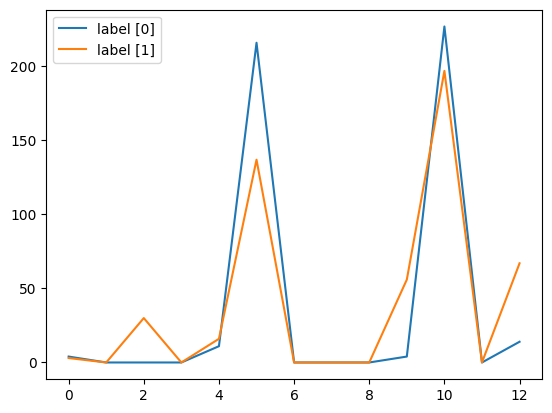

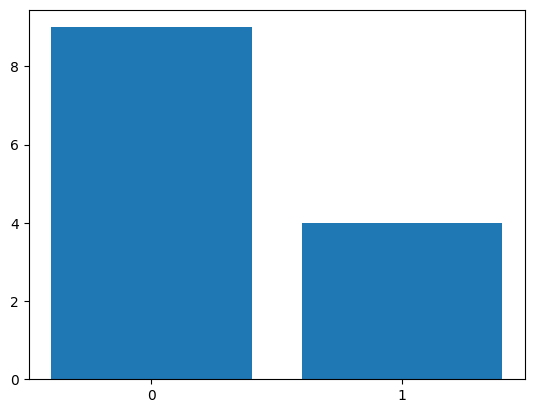

 Labeling lasted :  42.81493353843689  s


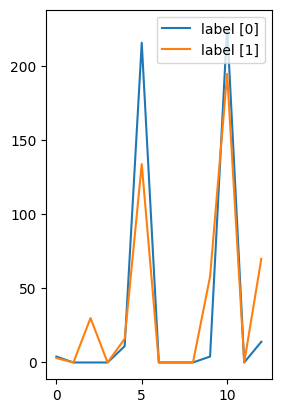

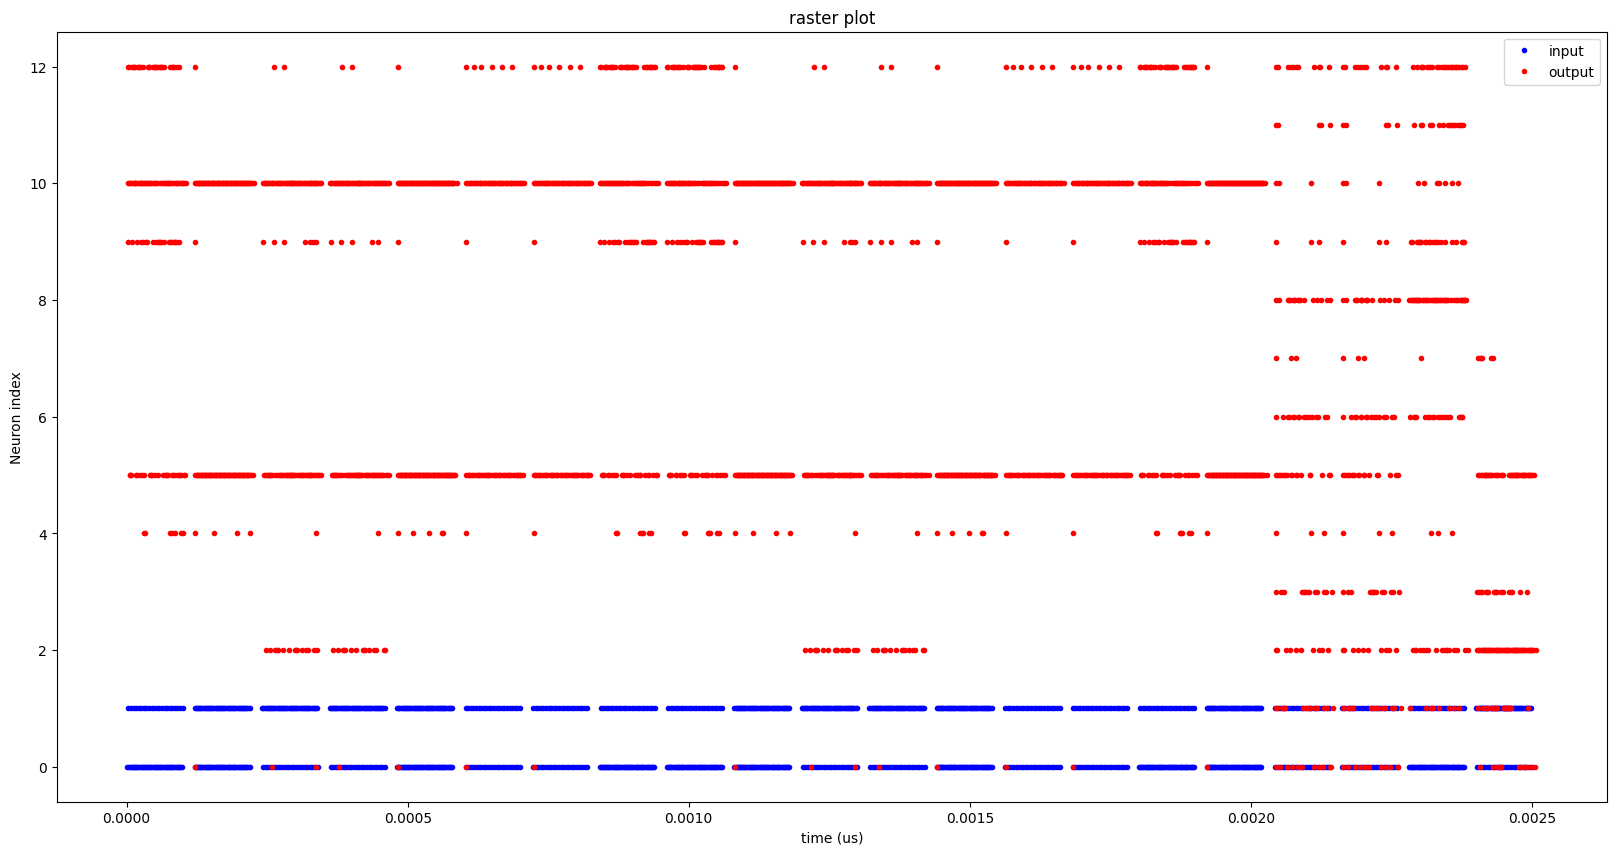

 TRAINING lasts :  76.75337195396423  s
accuracy_evol =  [0.5, 0.5, 0.75]


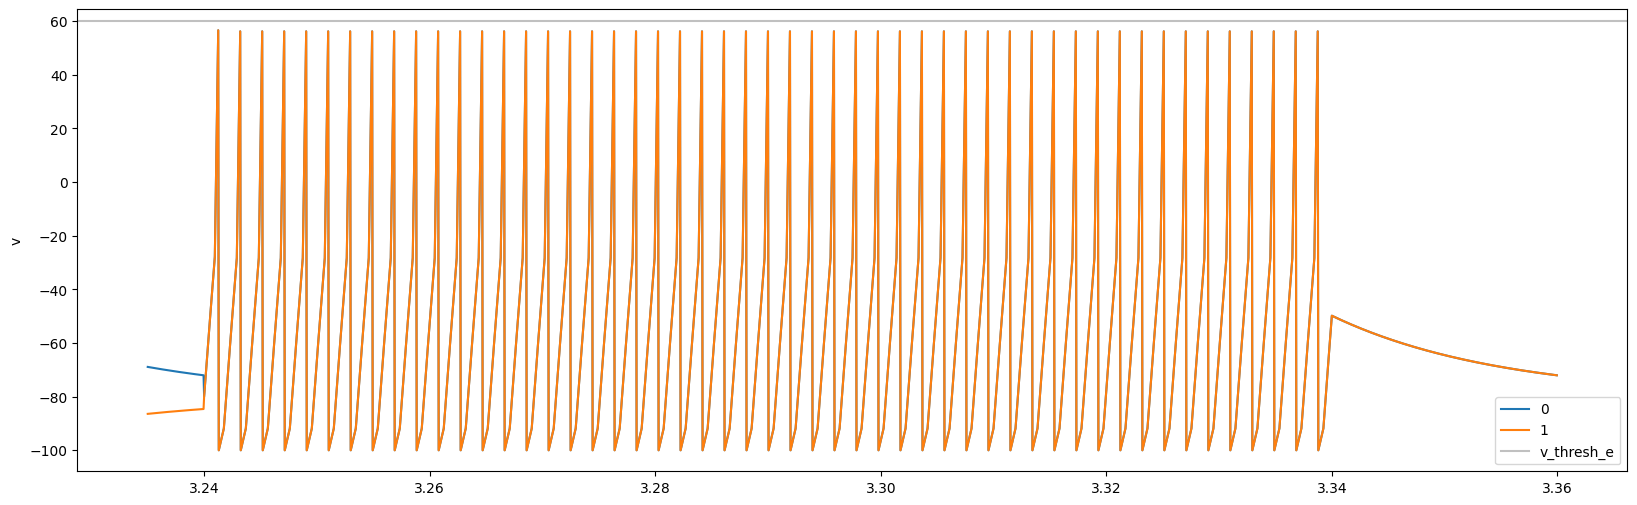

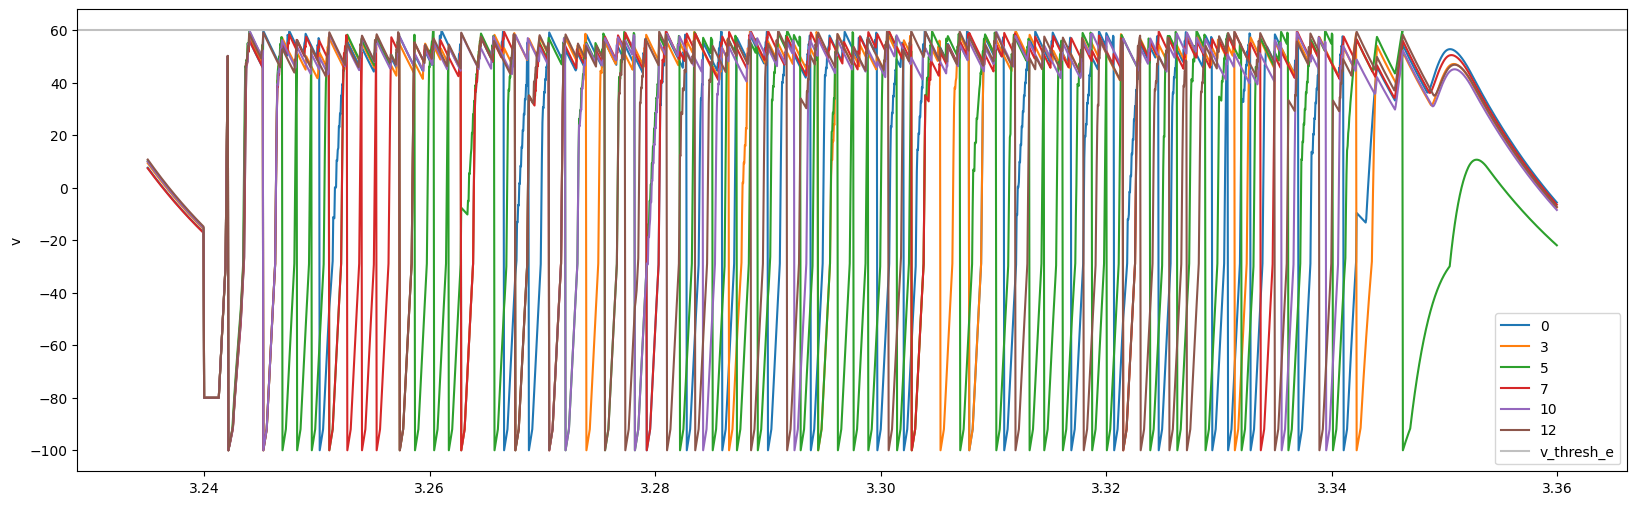

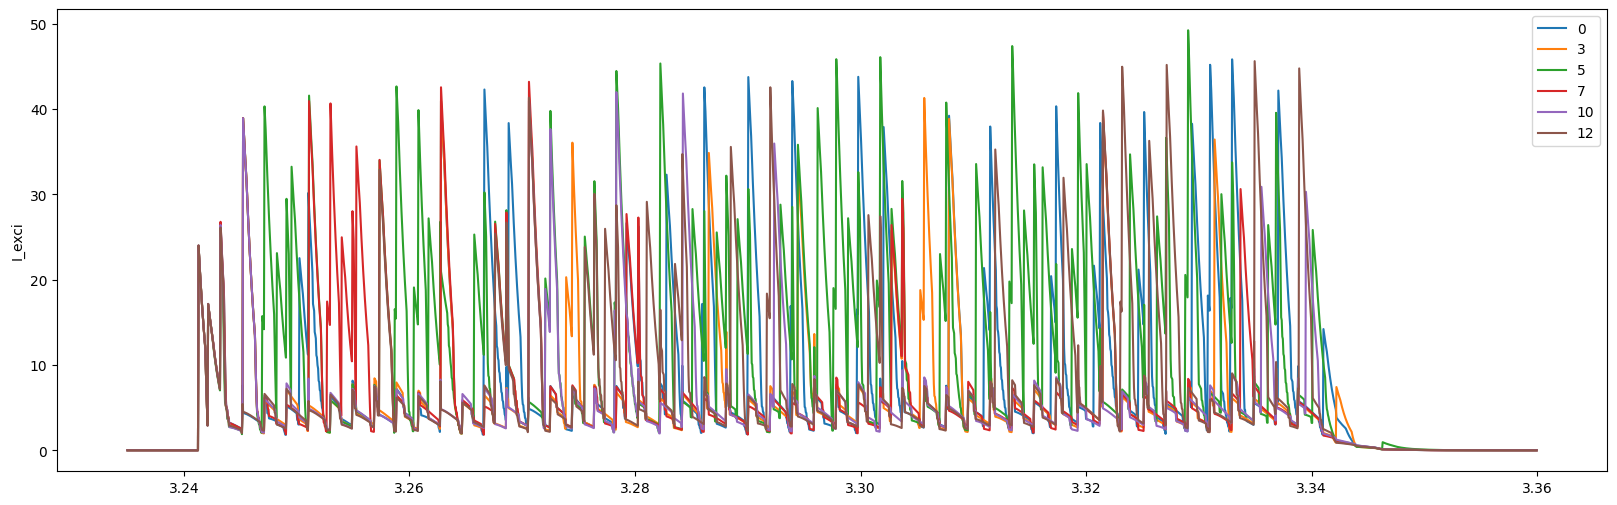

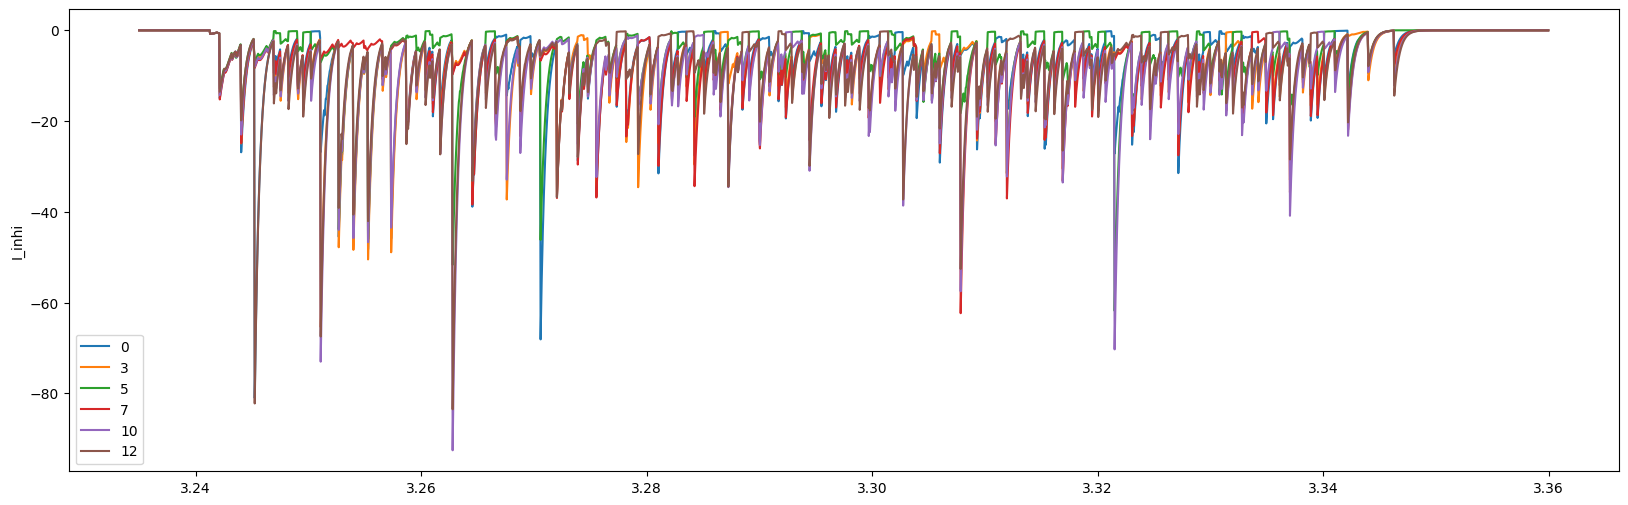

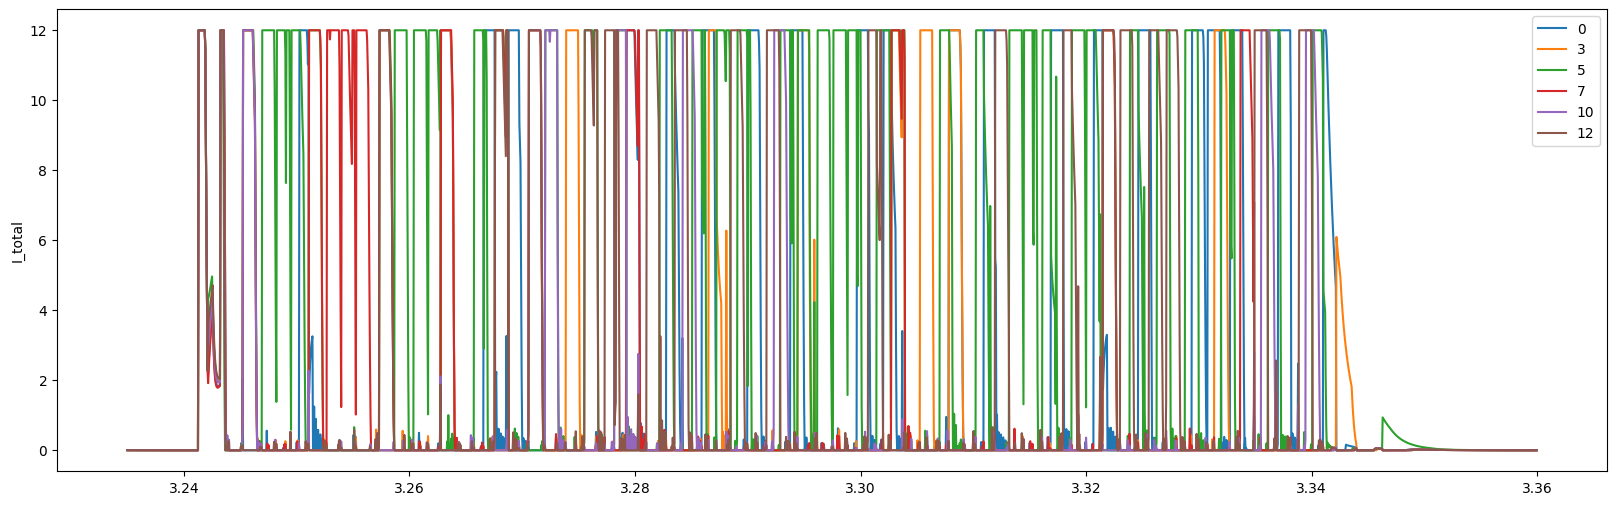

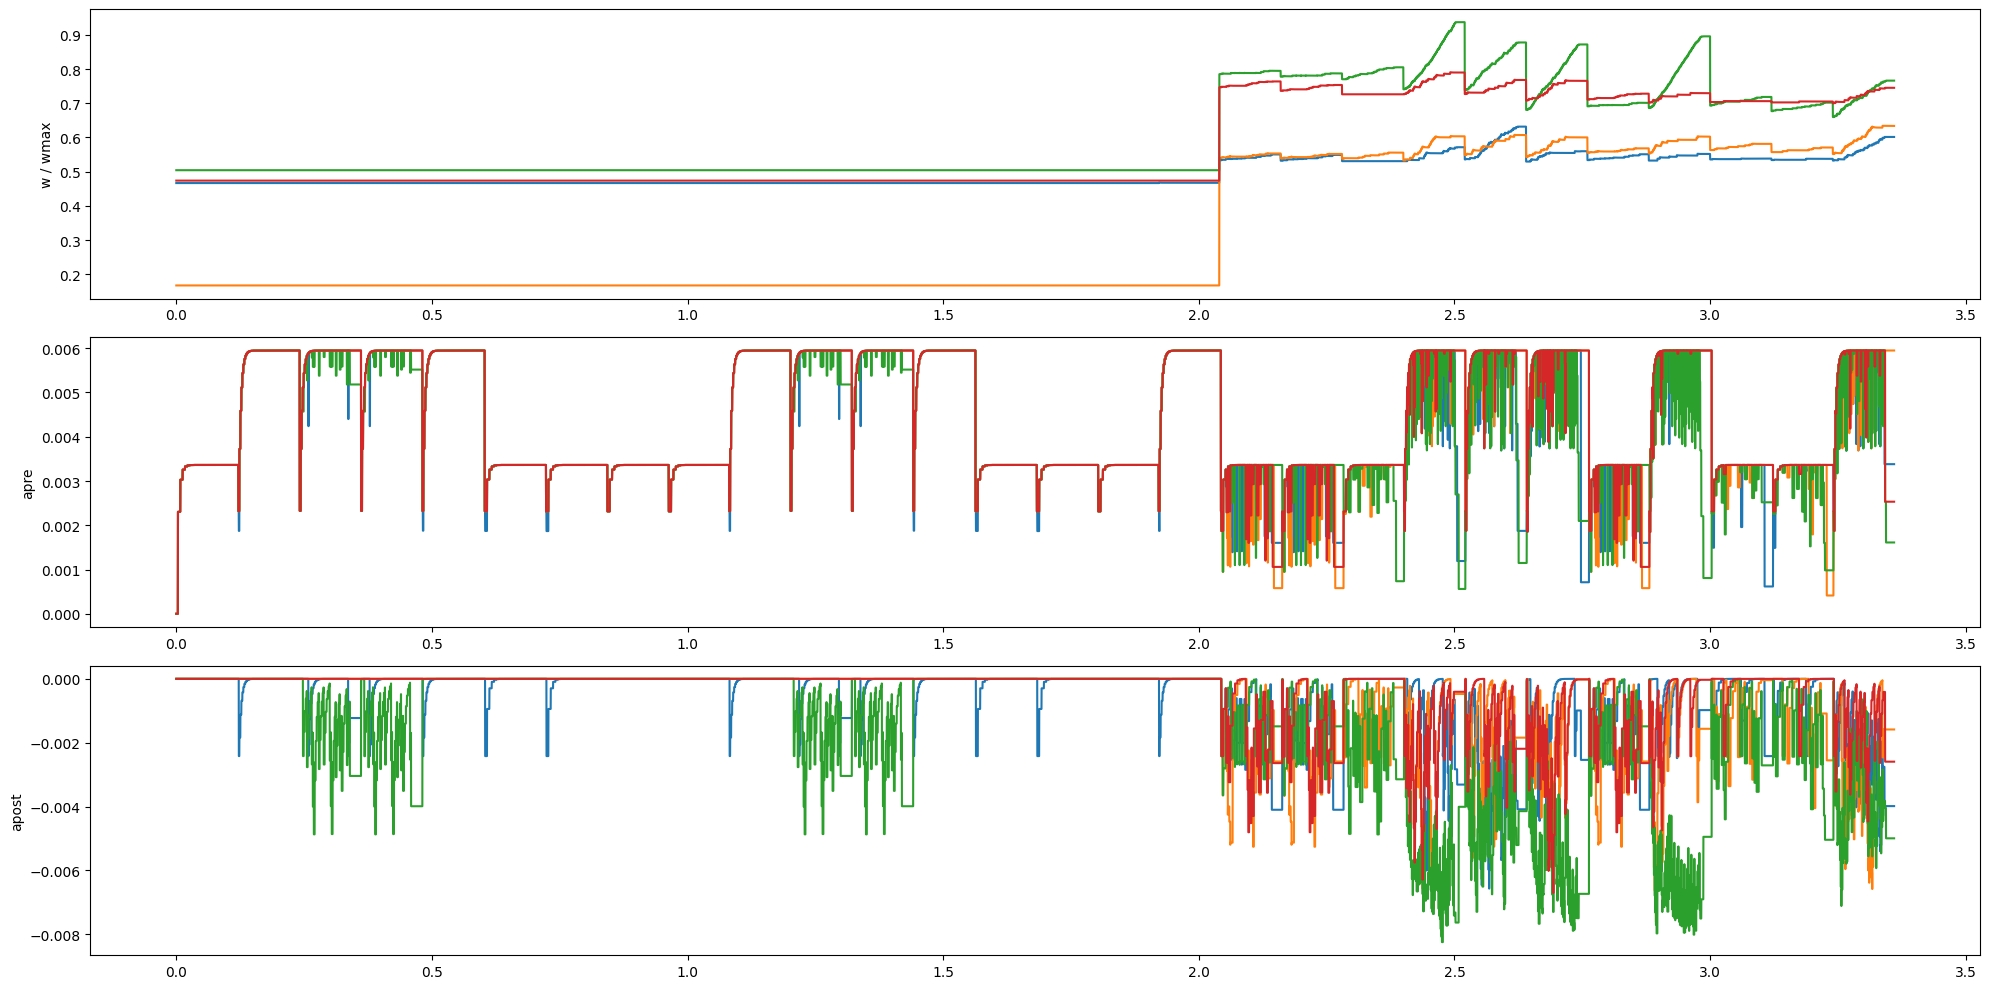

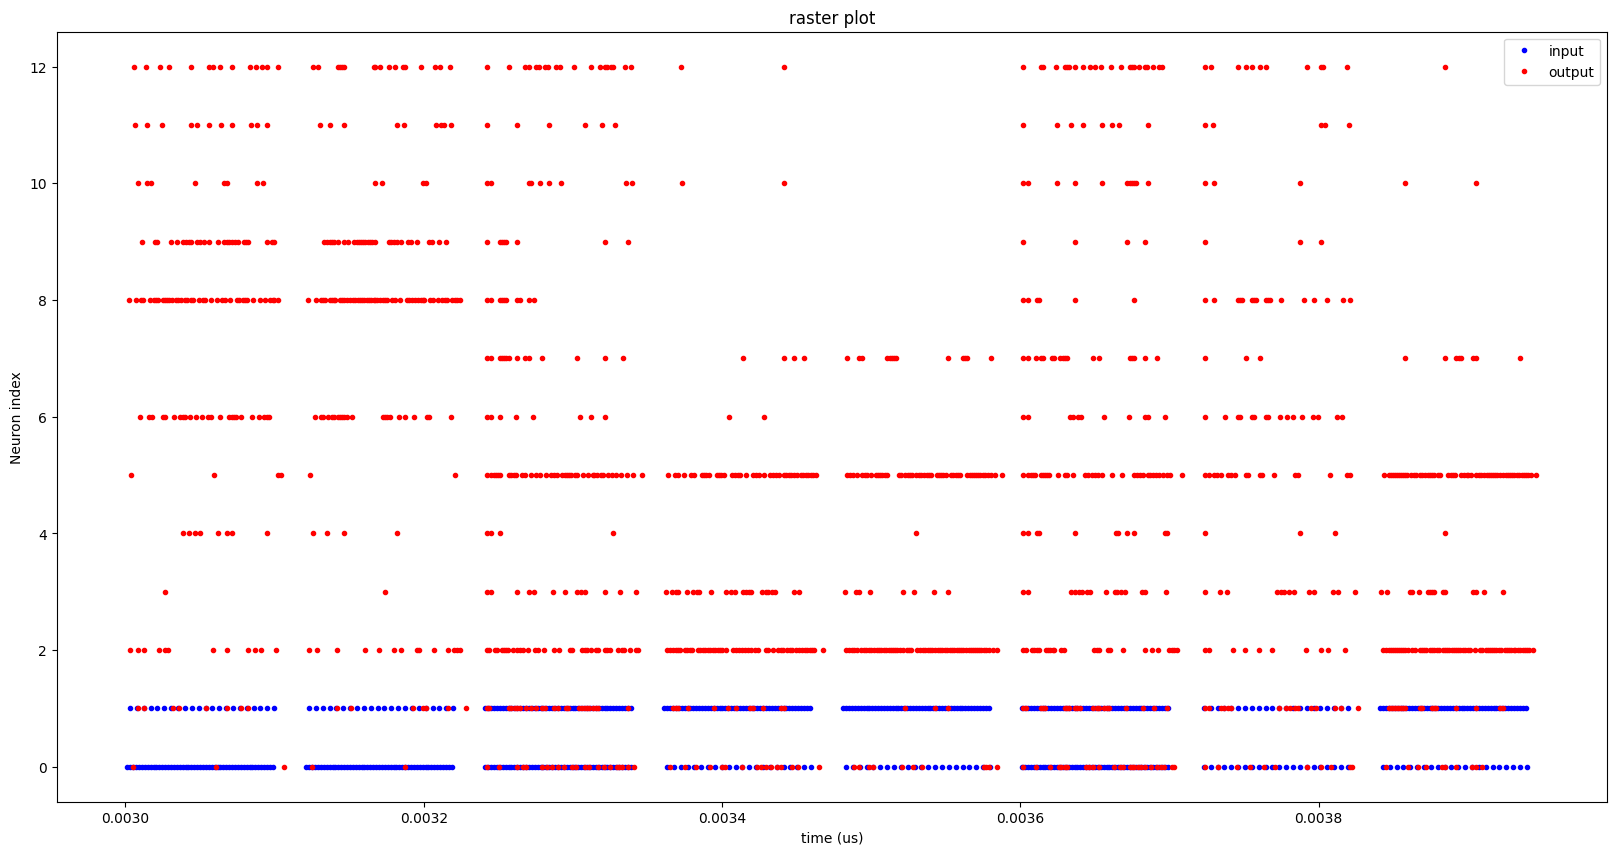

 TRAINING lasts :  76.45413565635681  s
accuracy_evol =  [0.5, 0.5, 0.75, 0.75, 0.5]


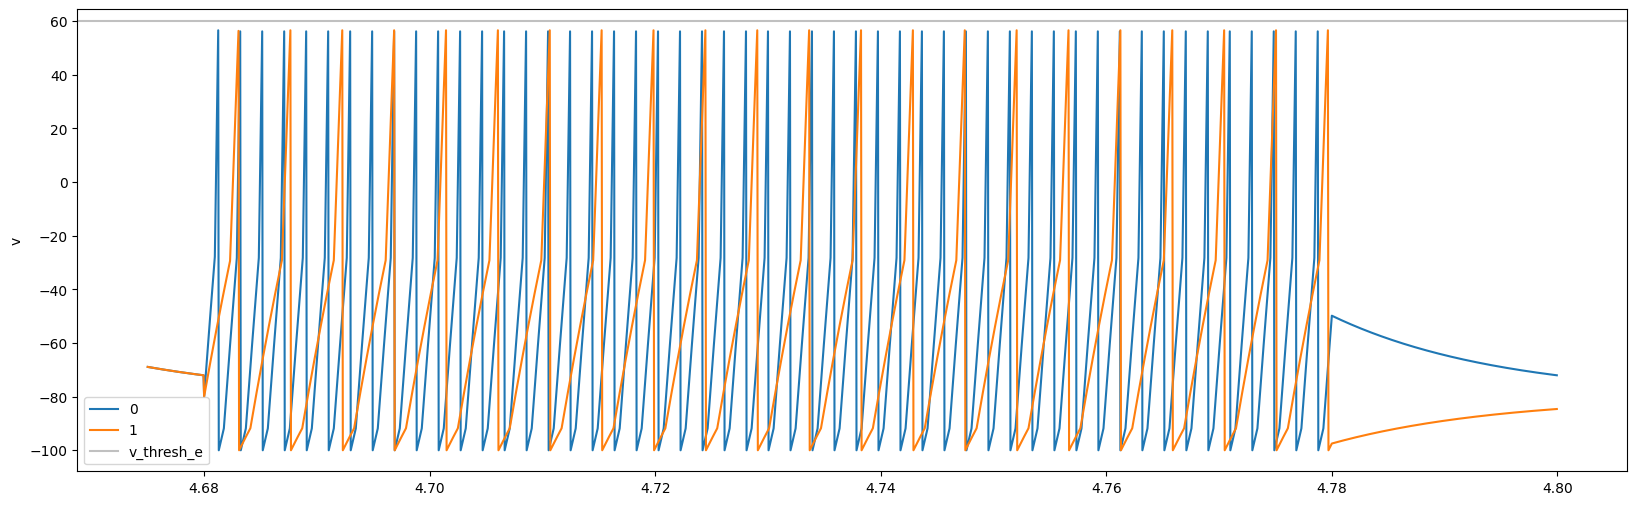

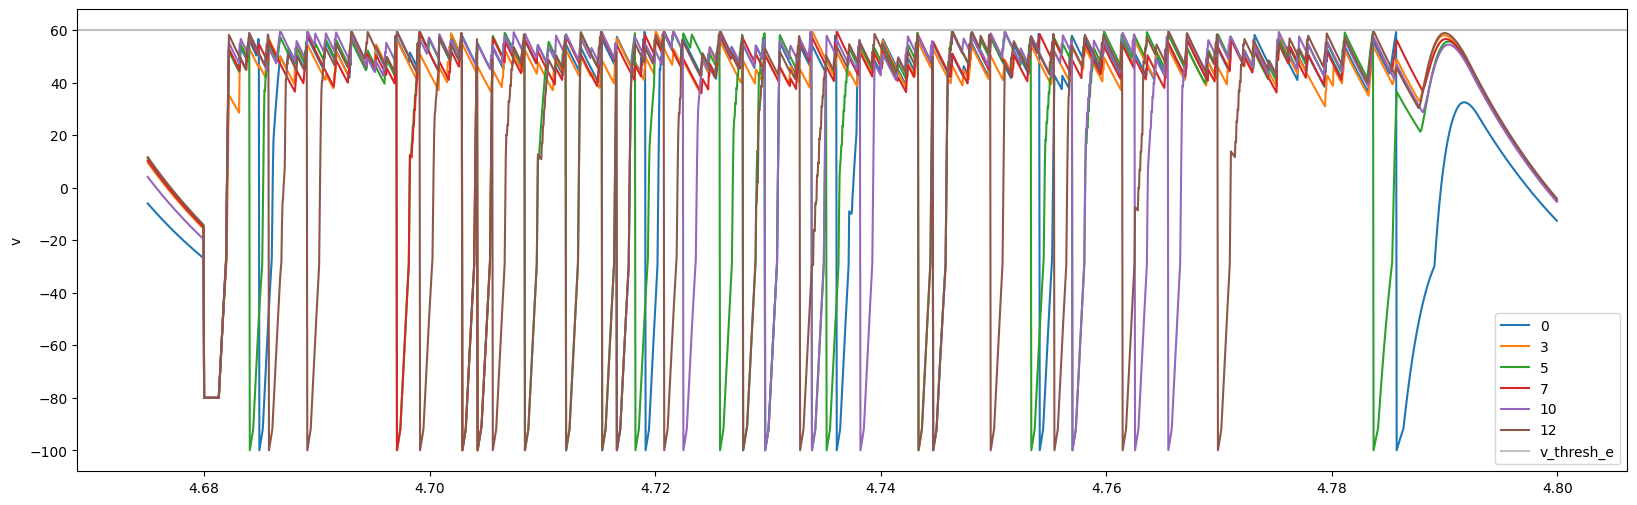

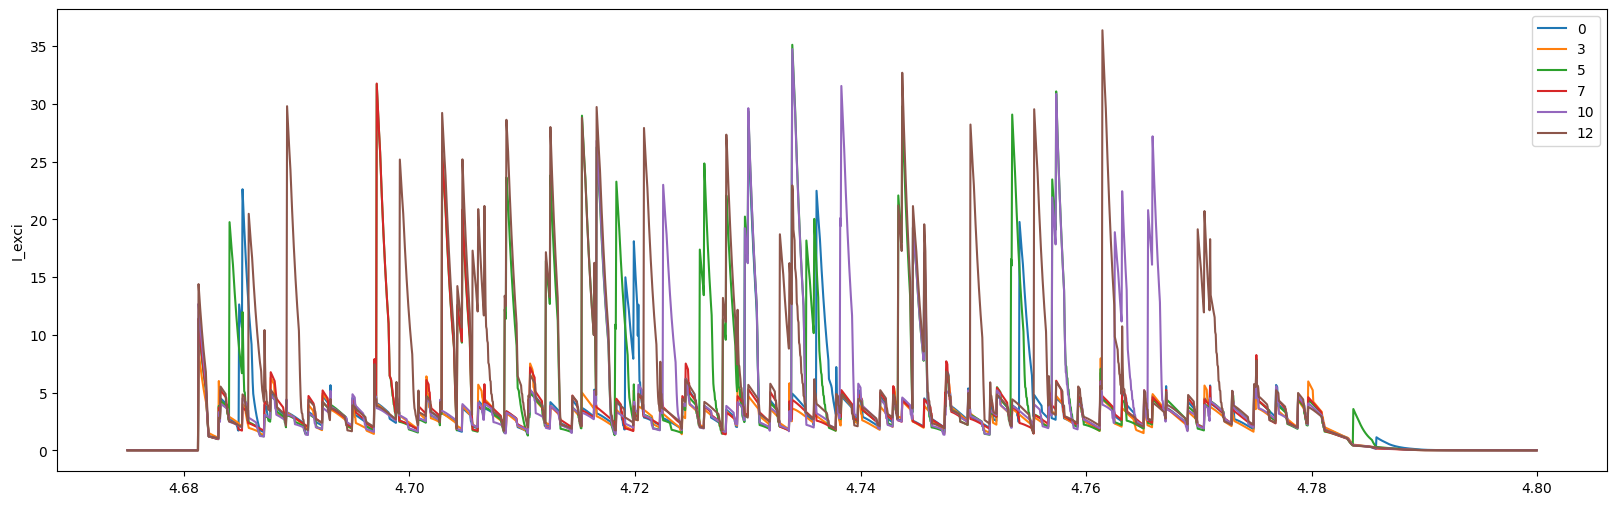

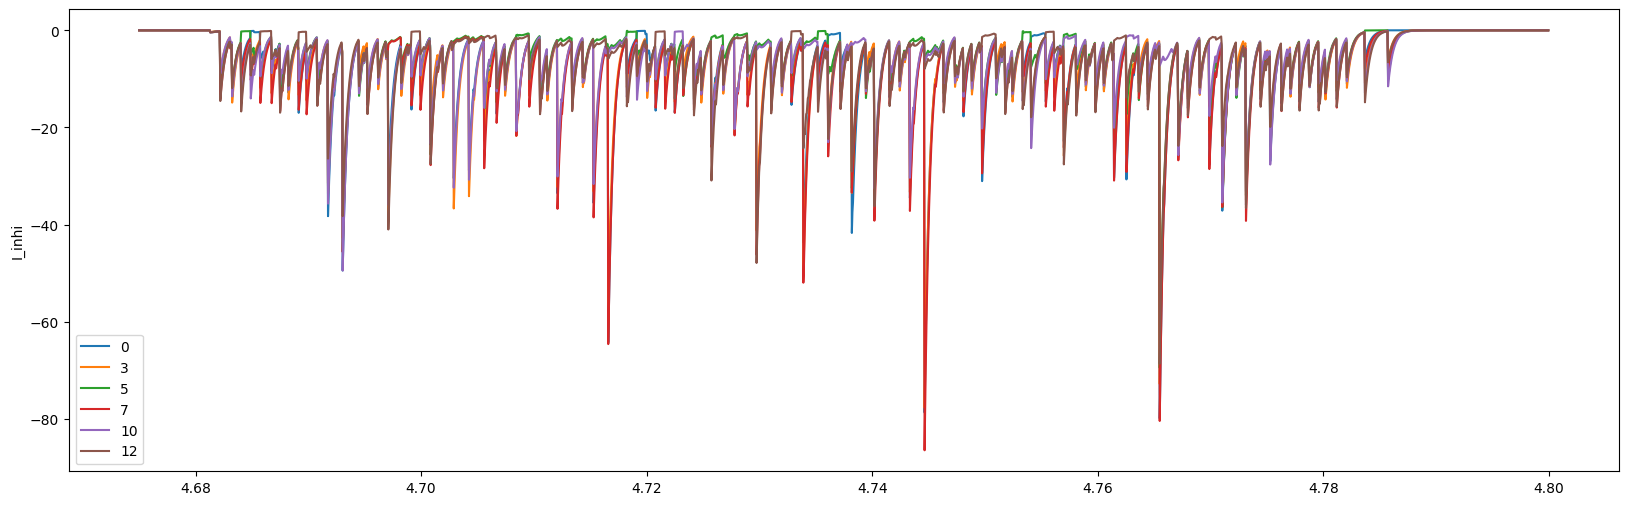

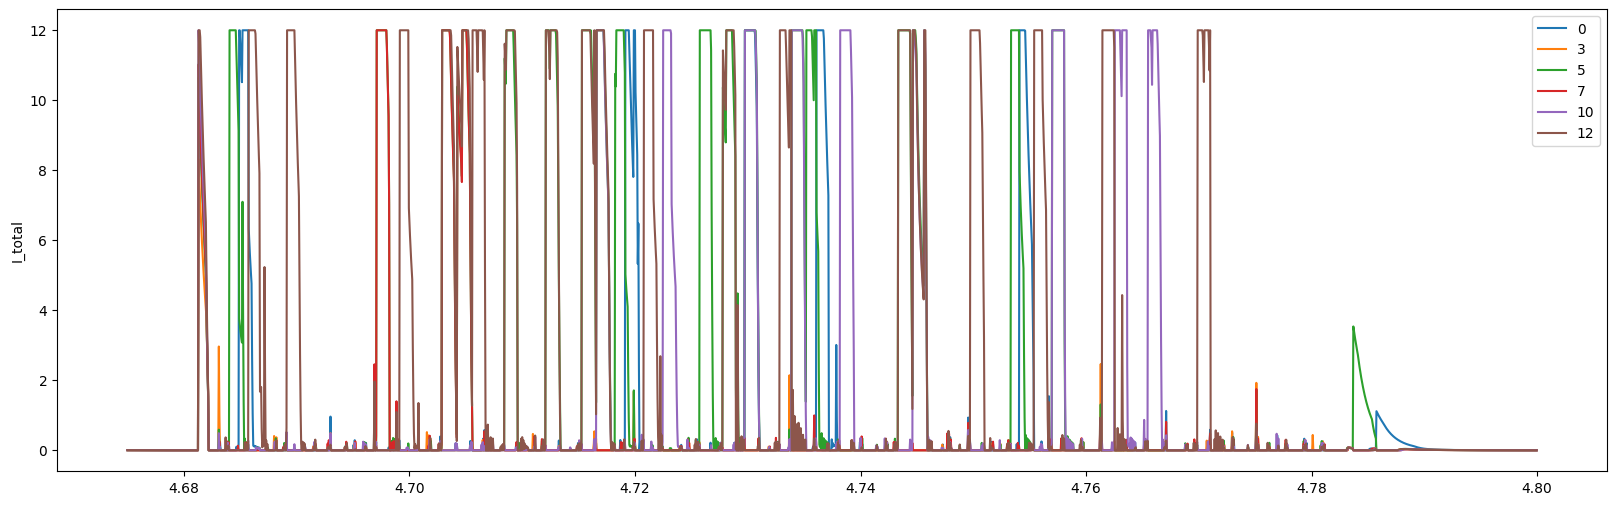

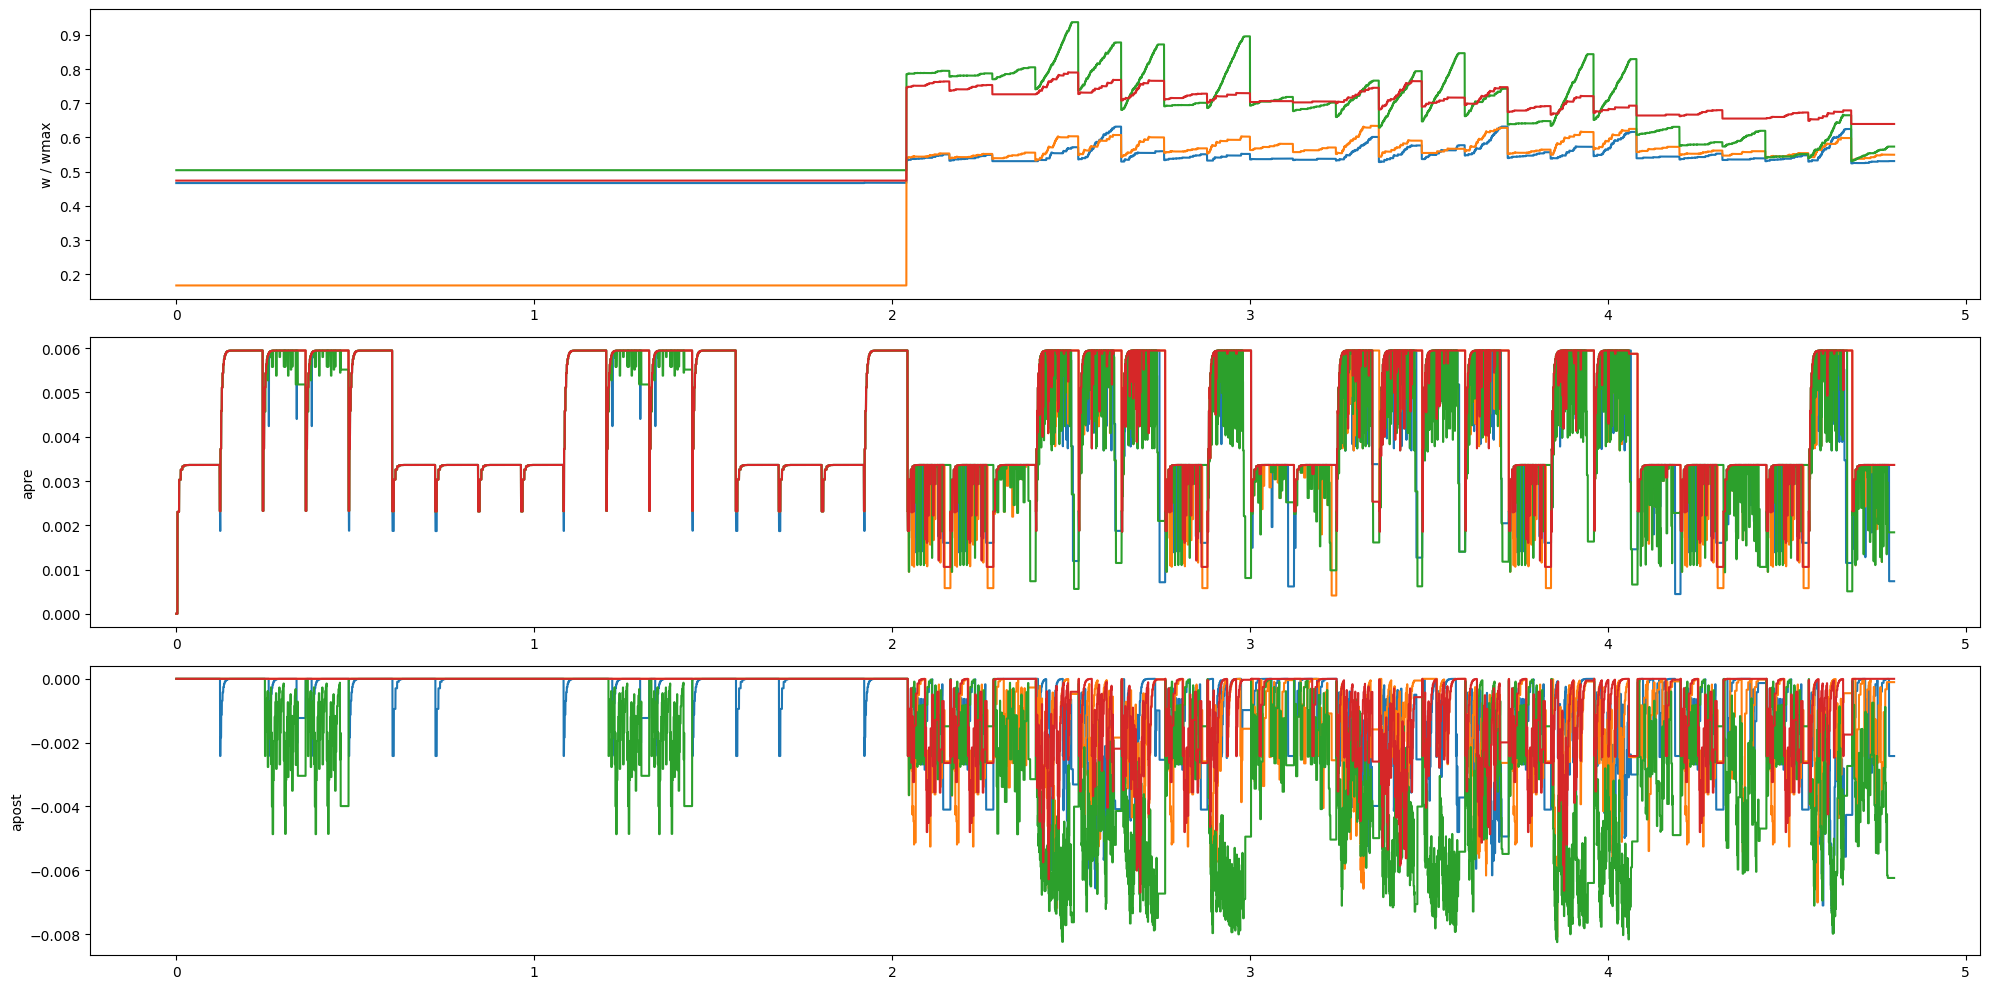

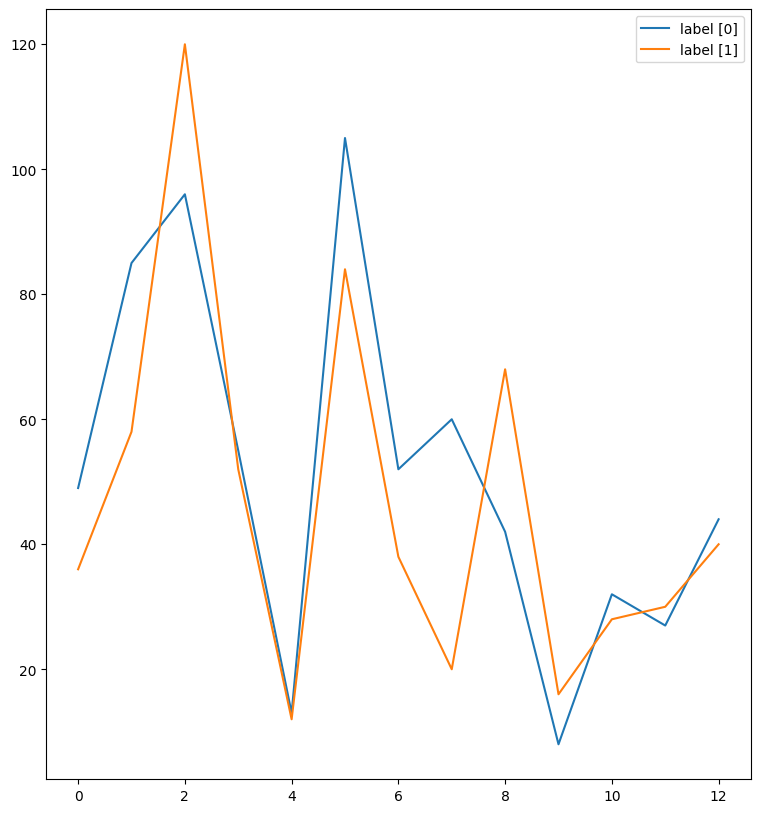

 Accuracy FINALE =  0.5
 eval done in  54.474501848220825  s 

 DONE with assessing_cst_sd_noise  303.348256111145 s 



In [4]:
directory = 'directory_name'
itera = 0
def assessing_cst_sd_noise(iterat,dir_name,noise=False,save_secure=False):
    '''
        Function that assesses the network by training, labeling, evaluating, and plotting results for multiple iterations
    '''
    print(" STARTING assessing_cst_sd_noise: \n")
    tac = time.time()
    
    epoch_max = 2
    save_secure = True
    
    
    global directory
    global itera
    directory = dir_name
    itera = iterat
    os.makedirs(directory,exist_ok=True)
    
    if save_secure:
        os.makedirs(directory+str(itera),exist_ok=True)

    n_train,n_test = 3,2 #It means one epoch is composed of 10*[[0,0],[0,1],[1,0],[1,1]] (shuffled)
    
    # Creating the SNN model
    debug = True
    model = SNN_eNeuron(debug=debug)

    #First evaluation before training:
    X_train,y_train,X_test,y_test = batch_data(n_train,n_test)
    model.labelisation(0,X_test,y_test,noise,plot=debug)
    accuracy_max,weight_evol_exci,weight_evol_inhi,label_buffer = model.evaluation(0,X_test,y_test,noise=True,plot=debug)
    

    #Training and Assesing
    for idx_epoch in range(epoch_max):
        # Creating batch data
        X_train,y_train,X_test,y_test = batch_data(n_train,n_test)


        accuracy_evol, label_buffer,accuracy_buffer,weight_evol_exci,weight_evol_inhi = model.training(idx_epoch,X_train,y_train,noise=noise,plot=debug,save_secure=save_secure)
        #model.labelisation(idx_epoch,X_train,y_train,noise=noise,plot=debug)

        #accuracy_max,accuracy_2,weight_evol_exci,weight_evol_inhi,labeled_neurons2 = model.evaluation(idx_epoch,X_test,y_test,noise=True,plot=debug)
        #accuracy_evol.append(accuracy_max)
        
        print("accuracy_evol = ", accuracy_evol)
        
        plot_v(model['ISM'], neurons=[0,1])
        plot_v(model['ESM'], neurons=[0,3,5,7,10,12])
        plot_ie(model['ESM'], neurons=[0,3,5,7,10,12])
        plot_ii(model['ESM'], neurons=[0,3,5,7,10,12])
        plot_itt(model['ESM'], neurons=[0,3,5,7,10,12])
        plot_w(model['S1M'])
        print(" \n  \n  \n  \n  \n")
        
        if accuracy_evol[-1] >= 0.95:
            break
            
         
    csv_save(f'{directory}/saving_nb_epoch_converging_n13.csv',[idx_epoch+1])
    csv_save(f'{directory}/saving_accuracy_max_n13.csv',accuracy_evol)

    #3D plot after training's done
    #X_3D,Y_3D,Z_3D = model.plot_3D_XOR(idx_epoch,n_point=10,noise=True,plot=False)
    #csv_save(f'{directory}/saving_Z_3D_n13.csv',Z_3D)

    if True:
        # Plot weight evolution
        weight_evolution(weight_evol_exci,weight_evol_inhi,label_buffer)

    save_accuracy_txtfile(f"{directory}/Accuracy_nb_epoch_save.txt", n_output, idx_epoch+1, accuracy_max,np.array([accuracy_max]))

    # Plot accuracy evolution
    plot_accuracy_evol(accuracy_evol,n_output)
    
    # Keep evaluating because there is no guarantee of 100% accuracy even if it's achieve once compared to without_noise
    #if final_idx+1 < epoch_max:
    if True:
        for _ in range(1):
            tic = time.time()
            X_train,y_train,X_test,y_test = batch_data(n_train,n_test=2)
            accuracy_max,weight_evol_exci,weight_evol_inhi,label_buffer = model.evaluation(idx_epoch,X_test,y_test,noise=True,plot=debug)
            accuracy_evol.append(accuracy_max)
            print(" Accuracy FINALE = ",accuracy_max)
            print(" eval done in ", time.time() - tic, " s \n")

    print(" DONE with assessing_cst_sd_noise ",time.time()-tac, "s \n")

    return idx_epoch+1, accuracy_max,weight_evol_exci,weight_evol_inhi,accuracy_evol,label_buffer


idx_epoch, accuracy_max,weight_evol_exci,weight_evol_inhi,accuracy_evol,label_buffer = assessing_cst_sd_noise(iterat=3,dir_name='directory_test',noise=False)

In [5]:
print(accuracy_evol)
print(weight_evol_exci[0])

[0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5]
[0.4717200415203831, 0.4562029544726484, 0.3711537049495686, 0.3184945881198858, 0.6104187471412579, 0.43514507162138455, 0.6695772406891004, 0.476449343105325, 0.7120673967048927, 0.6588295898525098, 0.51316176933119, 0.5931418643515557, 0.6545509278172574, 0.528279958479617, 0.5437970455273516, 0.6288462950504314, 0.6815054118801142, 0.389581252858742, 0.5648549283786154, 0.3304227593108995, 0.5235506568946751, 0.2879326032951072, 0.34117041014749017, 0.4868382306688099, 0.40685813564844436, 0.3454490721827427]


In [6]:
print(" len(weight_evol_exci) = ",len(weight_evol_exci))
print("len(weight_evol_exci[0]) = ", len(weight_evol_exci[0]))

 len(weight_evol_exci) =  2
len(weight_evol_exci[0]) =  26


## Weight evolution

In [7]:
itera = 5
print(type(directory+str(itera)))


<class 'str'>


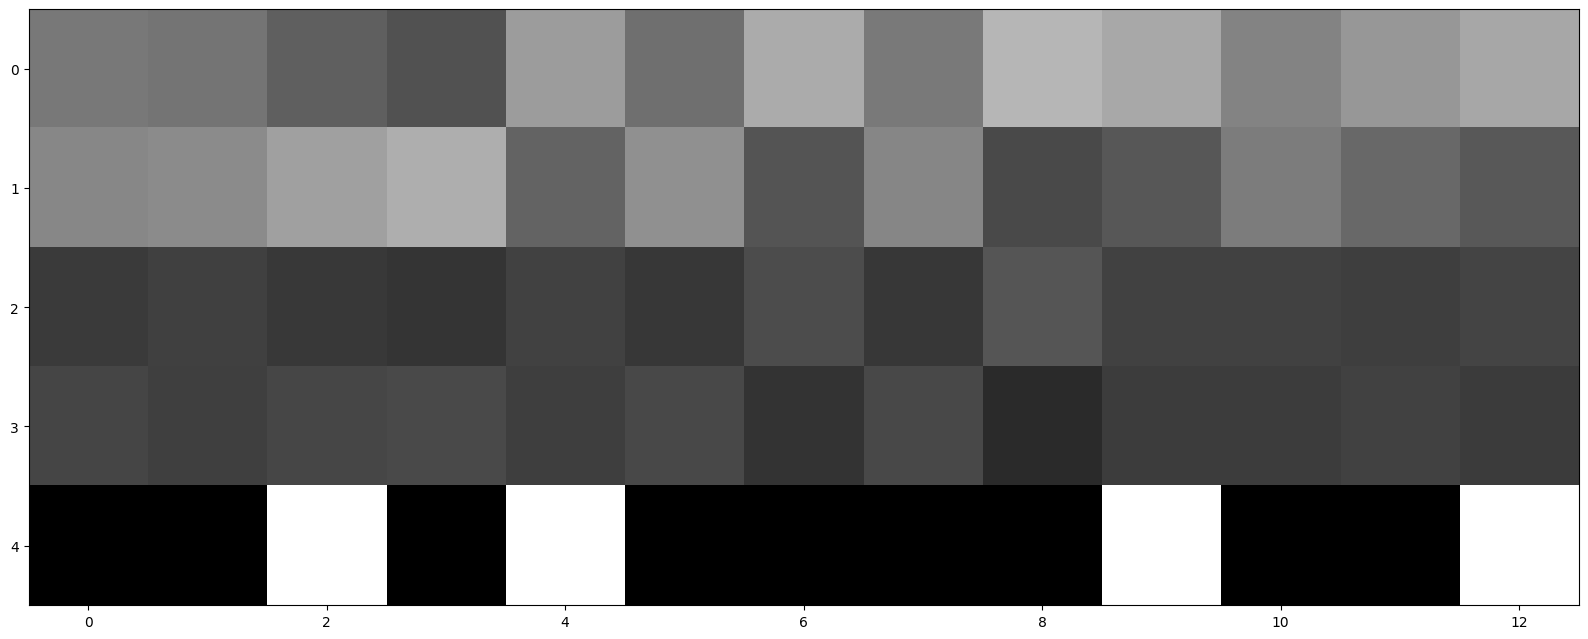

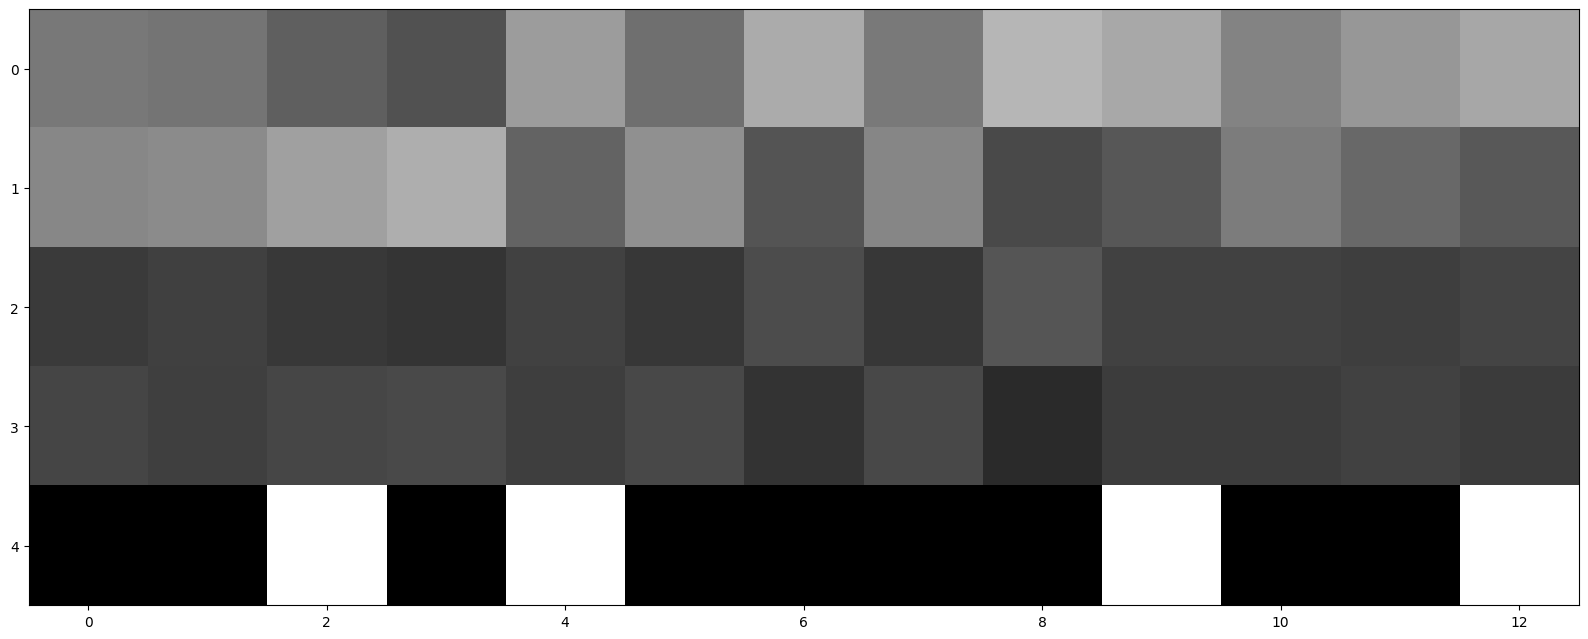

In [8]:
import matplotlib.pyplot as plt
import numpy as np


for k in range(len(weight_evol_exci)):
    
    weight_visu = np.zeros((5,13))
    weight_visu[:2,:] = np.reshape(weight_evol_exci[0], (2, 13))
    weight_visu[2:4,:] = np.reshape(weight_evol_inhi[0], (2, 13))
    weight_visu[4,:] = label_buffer

    plt.imshow(weight_visu, cmap='gray', interpolation='nearest')
    plt.show()
